In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [93]:
snp = pd.read_csv('/home/bwood/Desktop/Fun/snp500.csv')
snp.columns = snp.columns.str.replace('\xa0', ' ')
snp = snp.set_index('Symbol')
tickers = snp.index.values
snp.head()

,Security,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,Founded
Symbol,,,,,,
MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,1902
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1888
ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,2013 (1888)
ABMD,ABIOMED Inc,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,1981
ACN,Accenture plc,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1989


In [133]:
fullSnP = pd.read_csv('/home/bwood/Desktop/Fun/snp500-prices.csv')
fullSnP.set_index('timestamp', inplace=True)
fullSnP = fullSnP.sort_index(ascending=True)

#get SPY returns
spy_request = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=SPY&outputsize=full&apikey=B6BYXXQLAL2GVBOE&datatype=csv"
spyData = pd.read_csv(spy_request)
spyData = spyData.set_index('timestamp')['close'].rename('SPY')
fullSnP = fullSnP.join(spyData)

# the following have class A and B/C shares, drop them
dropDupes = ['GOOG', 'DISCK', 'FOX', 'NWS', 'UA']
fullSnP = fullSnP.drop(dropDupes, axis=1)
fullSnP.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS,SPY
timestamp,,,,,,,,,,,,,,,,,,,,,
2000-04-26,88.94,39.00,NaN,34.75,NaN,6.67,114.9,82.25,NaN,85.50,...,22.25,28.00,65.50,NaN,34.44,54.56,NaN,42.94,NaN,NaN
2000-04-27,87.44,39.00,NaN,34.00,NaN,6.75,123.4,85.25,NaN,84.44,...,22.06,27.06,72.63,NaN,35.56,56.63,NaN,41.44,NaN,NaN
2000-04-28,86.63,38.44,NaN,37.13,NaN,6.25,120.9,87.50,NaN,89.94,...,21.81,26.50,73.25,NaN,33.88,57.00,NaN,41.50,NaN,NaN
2000-05-01,86.94,38.06,NaN,34.69,NaN,6.25,130.7,88.38,NaN,87.88,...,22.13,27.06,71.63,NaN,33.69,57.38,NaN,41.75,NaN,147.0625
2000-05-02,86.94,38.19,NaN,34.75,NaN,6.81,115.5,89.50,NaN,85.00,...,22.06,26.50,67.19,NaN,33.81,52.44,NaN,42.94,NaN,144.1250


In [158]:
def getTopCorrs(beginDate, endDate, fullPrices):
    # filter to dates and drop columns with nans
    prices = fullPrices.loc[beginDate:endDate].dropna(axis=1)
    
    # get correlations between all stocks
    # each will have 1.0 with itself, replace this with a -1
    correlations = prices.corr()
    correlations.replace(1.0, -1.0, inplace=True)
    
    # grab the correlations to spy
    spyCorrs = correlations['SPY']
    
    # remove the spy column and spy row
    correlations.drop(['SPY'], axis=1, inplace=True)
    correlations = correlations[~correlations.index.isin(['SPY'])]
    
    # get the max values and argmax tickers for the correlations of each security
    topCorrs = correlations.idxmax(axis=1).rename('ticker_b').to_frame().join(correlations.max(axis=1).rename('correlation'))
    topCorrs = topCorrs.sort_values('correlation', ascending=False)
    topCorrs = topCorrs.reset_index().rename(columns={'index':'ticker_a'})
    
    # add in spy correlation
    topCorrs = topCorrs.join(spyCorrs, on='ticker_a')
    
    # add in the security names
    topCorrs = topCorrs.join(snp[['Security']].rename(columns={'Security': 'security_a'}), on='ticker_a')
    topCorrs = topCorrs.join(snp[['Security']].rename(columns={'Security': 'security_b'}), on='ticker_b')
    
    # get rid of the duplicate pairs
    topCorrs = topCorrs.drop_duplicates('correlation')
    
    return topCorrs

In [168]:
corrs = getTopCorrs('2019-01-01', '2019-12-31', fullSnP)

In [169]:
corrs.head(10)

,ticker_a,ticker_b,correlation,SPY,security_a,security_b
0,ETR,NEE,0.992065,0.854065,Entergy Corp.,NextEra Energy
2,MA,V,0.991320,0.918489,Mastercard Inc.,Visa Inc.
4,CMS,WEC,0.990894,0.793840,CMS Energy,WEC Energy Group
6,FE,ETR,0.988734,0.858918,FirstEnergy Corp,Entergy Corp.
7,SO,ETR,0.986758,0.888499,Southern Company,Entergy Corp.
8,MCO,SPGI,0.985516,0.943019,Moody's Corp,"S&P Global, Inc."
10,LNT,CMS,0.985406,0.861545,Alliant Energy Corp,CMS Energy
11,GPN,MA,0.985132,0.929241,Global Payments Inc.,Mastercard Inc.
12,LMT,HIG,0.984938,0.847482,Lockheed Martin Corp.,Hartford Financial Svc.Gp.
14,XEL,WEC,0.983084,0.800609,Xcel Energy Inc,WEC Energy Group


In [170]:
returns = prices.apply(lambda x: (x / x[0]) - 1)

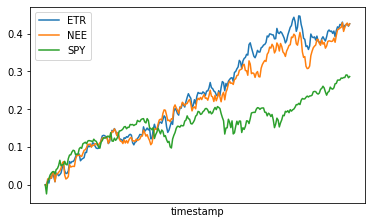

In [171]:
ax = returns[['ETR', 'NEE', 'SPY']].plot()
# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

plt.show()

# Notes
- Find pairs that are highly correlated but the SPY correlation is close to 0 (or -1 maybe?)
- Download the SPY prices into its own file